In [1]:
#
# Chapter 10, Example 3a: undercomplete AE
#

import os
import pylab
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers, models, losses

if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

In [2]:
# Load and prepare the MNIST dataset. 
mnist = tf.keras.datasets.mnist
(x_train, _), (x_test, _) = mnist.load_data()
# Normalize image to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
# Built Model
seed = 10
tf.random.set_seed(seed)
tf.keras.backend.set_floatx('float32')
class Autoencoder(Model):
    def __init__(self, n_input, n_hidden):
        super(Autoencoder, self).__init__()
        # Initialize the weights and biases
        self.W = tf.Variable(tf.keras.backend.truncated_normal([n_input, n_hidden], stddev=1/np.sqrt(n_input)))
        self.b = tf.Variable(tf.zeros([n_hidden]))
        self.b_prime = tf.Variable(tf.zeros([n_input]))

    def call(self, x):
        h = tf.sigmoid(tf.matmul(x, self.W) + self.b)
        y = tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.b_prime)
        return y

# Intialize an undercomplete AE with 100 hidden units
autoencoder = Autoencoder(n_input=28*28,n_hidden=100)

In [4]:
# Set an optimizer and loss function for training
optimizer = tf.optimizers.SGD(learning_rate=0.1)
def loss(y,original):
    mse_loss = tf.reduce_mean(tf.reduce_sum(tf.square(original - y), axis=1))
    return mse_loss

In [5]:
# Training function
def train(original):
    with tf.GradientTape() as tape:
        y = autoencoder(original)
        losses = loss(y, original)
        trainable_variables = [autoencoder.W,autoencoder.b,autoencoder.b_prime]
        gradients = tape.gradient(losses, trainable_variables)
        gradient_variables = zip(gradients, trainable_variables)
        optimizer.apply_gradients(gradient_variables)
    return losses

In [6]:
# Vectorize iamges 
x_train = tf.cast(x_train.reshape(x_train.shape[0],28*28), tf.float32)
x_test = tf.cast(x_test.reshape(x_test.shape[0],28*28), tf.float32)
# Use tf.data to batch and shuffle the train dataset
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)

In [7]:
# Main function: train the model
no_epochs = 50
print('Training starts...')
l = [] 
for i in range(no_epochs):
    l_ = []
    for images in train_ds:
        l_.append(train(images))
    l.append(np.mean(l_))
    if i%1 == 0:
        print('epoch: %d, loss: %f'%(i, l[i]))

Training starts...
epoch: 0, loss: 30.664259
epoch: 1, loss: 19.086445
epoch: 2, loss: 16.200327
epoch: 3, loss: 14.640198
epoch: 4, loss: 13.614895
epoch: 5, loss: 12.867767
epoch: 6, loss: 12.287981
epoch: 7, loss: 11.816315
epoch: 8, loss: 11.416716
epoch: 9, loss: 11.070416
epoch: 10, loss: 10.763865
epoch: 11, loss: 10.488517
epoch: 12, loss: 10.238949
epoch: 13, loss: 10.008870
epoch: 14, loss: 9.796309
epoch: 15, loss: 9.600538
epoch: 16, loss: 9.419501
epoch: 17, loss: 9.252226
epoch: 18, loss: 9.100400
epoch: 19, loss: 8.960109
epoch: 20, loss: 8.831288
epoch: 21, loss: 8.714410
epoch: 22, loss: 8.606524
epoch: 23, loss: 8.508315
epoch: 24, loss: 8.417257
epoch: 25, loss: 8.334242
epoch: 26, loss: 8.257750
epoch: 27, loss: 8.188007
epoch: 28, loss: 8.122145
epoch: 29, loss: 8.061889
epoch: 30, loss: 8.005807
epoch: 31, loss: 7.953129
epoch: 32, loss: 7.904156
epoch: 33, loss: 7.858051
epoch: 34, loss: 7.814682
epoch: 35, loss: 7.774539
epoch: 36, loss: 7.737082
epoch: 37, loss

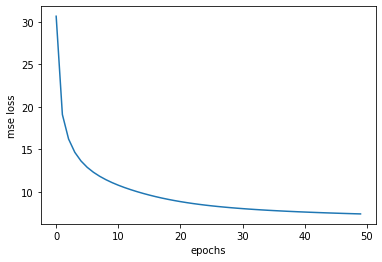

In [8]:
# Plot the loss curve
pylab.figure()
pylab.plot(range(no_epochs), l)
pylab.xlabel('epochs')
pylab.ylabel('mse loss')
pylab.savefig('./figures/10.3a_1.png')

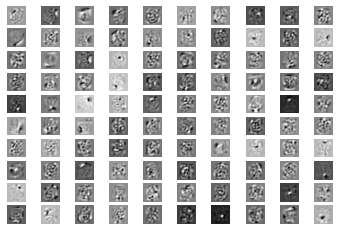

In [13]:
# Show the weights of autoencoder
pylab.figure()
pylab.gray()
for i in range(100):
    pylab.subplot(10, 10, i+1); pylab.axis('off'); pylab.imshow(np.array(autoencoder.W[:,i]).reshape(28,28))
pylab.savefig('./figures/10.3a_2.png')

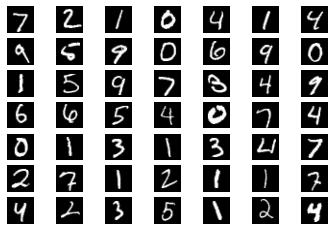

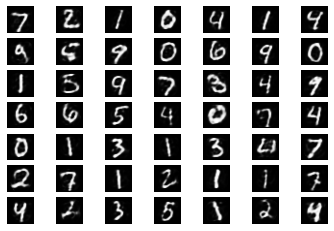

In [12]:
# Show test input image
pylab.figure()
pylab.gray()
for i in range(49):
    pylab.subplot(7, 7, i+1); pylab.axis('off'); pylab.imshow(np.array(x_test[i,:]).reshape(28,28))
pylab.savefig('./figures/10.3a_3.png')

# Show reconstructed image
x_test_out = autoencoder(tf.cast(x_test, tf.float32))
pylab.figure()
pylab.gray()
for i in range(49):
    pylab.subplot(7, 7, i+1); pylab.axis('off'); pylab.imshow(np.array(x_test_out[i,:]).reshape(28,28))
pylab.savefig('./figures/10.3a_4.png')

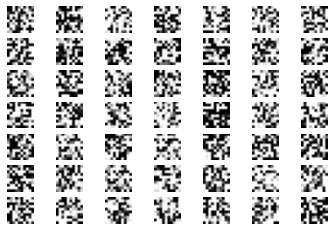

In [14]:
# Hidden layer activations of 49 test patterns
h = tf.sigmoid(tf.matmul(tf.cast(x_test, tf.float32), autoencoder.W) + autoencoder.b)
pylab.figure()
pylab.gray()
for i in range(49):
    pylab.subplot(7, 7, i+1); pylab.axis('off'); pylab.imshow(np.array(h[i,:]).reshape(10,10))
pylab.savefig('./figures/10.3a_5.png')